# Load datasets and import libraries

In [ ]:
import os, sys
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Import all other necessary libraries
from IPython.display import clear_output
import seaborn as sns
sns.set_theme()
import pandas as pd
import numpy as np
import torch
import requests
import tqdm
import time
import urllib.parse
import json
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import random
import csv

# Preprocessing
import nltk
import pprint
nltk.download('punkt')
import re
from nltk.tokenize.api import TokenizerI
from nltk.tokenize.util import regexp_span_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

clear_output()

*End of setup*

--------------------------------------------------------------------------------

In [ ]:
# Load CNNDM dataset from HuggingFace
! pip install datasets
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail","3.0.0")
clear_output()

In [ ]:
print('Training articles =', len(dataset['train']))
print('Validation articles =', len(dataset['validation']))
print('Testing articles =', len(dataset['test']))

Training articles = 287113
Validation articles = 13368
Testing articles = 11490


### Filter datasets for opinion articles

In [ ]:
# For CNNDM dataset, use keyphrase 'opinions expressed' to identify opinion pieces.
def filter_opinions(dataset):
    start_time = time.time()
    opinions = dataset.filter(lambda x: 'opinions expressed in this' in x['article'])
    clear_output()
    print('--- Finished in %s seconds ---' % (time.time() - start_time))
    print('New corpus size =', len(opinions))
    return opinions

In [ ]:
# For CNNDM dataset, use keyphrase 'opinions expressed' to identify opinion pieces.
def filter_non_opinions(dataset):
    start_time = time.time()
    non_opinions = dataset.filter(lambda x: 'opinions expressed' not in x['article'])
    clear_output()
    print('--- Finished in %s seconds ---' % (time.time() - start_time))
    print('New corpus size =', len(non_opinions))
    return non_opinions

In [ ]:
corpus = filter_opinions(dataset['train'])

--- Finished in 4.444366931915283 seconds ---
New corpus size = 4898


In [ ]:
extra_corpus = filter_non_opinions(dataset['train'])

--- Finished in 5.019664525985718 seconds ---
New corpus size = 282163


### Preprocess articles

In [ ]:
def preprocess(article):
  
    # Split into list of sentences
    sent_list = nltk.tokenize.sent_tokenize(article)

    # Remove extraneous info from start of article
    for i, sent in enumerate(sent_list):

        if "(CNN) --" in sent:
            index = sent.find('(CNN) --')
            new_sent = ""
            new_sent = [new_sent+char for idx, char in enumerate(sent_list[i]) if idx > index+8]
            new_sent = ''.join((str(n) for n in new_sent))
            sent_list[i] = new_sent
            sent_list = sent_list[i:-1]

    return sent_list

# I. Data Exporation

#### Sentences per article

In [ ]:
# Function for CNNDM analysis
def get_sentence_info(corpus):
  
    df = pd.DataFrame(corpus)
    for column in ['article', 'highlights']:
        # Get number of sentences and words for each article and summary
        sentences = []
        num_sentences = []
        num_words = []
        for idx, art in enumerate(corpus):
            sent_list = preprocess(art[column])
            sentences.append(sent_list)
            word_count = 0
            for sent in sent_list:
                words = sent.split(' ')
                word_count += len(words)
            num_sentences.append(len(sent_list))
            num_words.append(word_count)

        df[f'{column}_sentences'] = sentences
        df[f'{column}_num_sentences'] = num_sentences
        df[f'{column}_num_words'] = num_words
    return df

In [ ]:
# Function for AMR Proxy analysis
def get_amr_sentence_info(story_loc, summary_loc):

    with open(story_loc, 'r') as f:
        stories = f.readlines()

    with open(summary_loc, 'r') as g:
        summaries = g.readlines()

    df = pd.DataFrame()
    temp_df = pd.DataFrame()
    temp_df['article'] = stories
    temp_df['highlights'] = summaries

    for column in ['article', 'highlights']:
    # Get number of sentences and words for each article and summary
        sentences = []
        num_sentences = []
        num_words = []
        for idx, art in enumerate(temp_df[column]):
            sent_list = preprocess(art)
            sentences.append(sent_list)
            word_count = 0
            for sent in sent_list:
                words = sent.split(' ')
                word_count += len(words)
            num_sentences.append(len(sent_list))
            num_words.append(word_count)

        df[f'{column}_sentences'] = sentences
        df[f'{column}_num_sentences'] = num_sentences
        df[f'{column}_num_words'] = num_words

    return df

In [ ]:
# Update dataset
story_loc = '/content/drive/MyDrive/IP/datasets/all_stories.txt'
summary_loc = '/content/drive/MyDrive/IP/datasets/all_summaries.txt'
df1 = get_amr_sentence_info(story_loc, summary_loc)

In [ ]:
df1 = get_sentence_info(corpus)

For CNNDM

In [ ]:
sns.set(rc={'figure.figsize':(12,4)})
fig, (ax1, ax2) = plt.subplots(1,2)

sns.histplot(data=df1, x='article_num_sentences', bins=50, ax=ax1)
ax1.set_xlabel("Number of article sentences", fontsize = 12)
ax1.axvline(x=df1['article_num_sentences'].median(),color='blue',ls='--', lw=1.5)
ax1.text(50, 520, f"Median={df1['article_num_sentences'].median()}", horizontalalignment='left', size='medium', color='blue')
ax1.axvline(x=df1['article_num_sentences'].mean(),color='black',ls='--', lw=1.5)
ax1.text(50, 480, f"Mean={df1['article_num_sentences'].mean().round(1)}", horizontalalignment='left',size='medium', color='black')
ax1.set_title('a)')

sns.histplot(data=df1, x='highlights_num_sentences', bins=np.arange(1,9), ax=ax2)
ax2.set_xlabel("Number of summary sentences", fontsize = 12)
ax2.axvline(x=df1['highlights_num_sentences'].median(),color='blue',ls='--', lw=1.5)
ax2.text(1.8, 3000, f"Median={df1['highlights_num_sentences'].median()}", horizontalalignment='left', size='medium', color='blue')
ax2.axvline(x=df1['highlights_num_sentences'].mean(),color='black',ls='--', lw=1.5)
ax2.text(1.8, 2750, f"Mean={df1['highlights_num_sentences'].mean().round(1)}", horizontalalignment='left',size='medium', color='black')
ax2.set_title('b)')

plt.savefig('/content/sample_data/sentence_dist.png', , dpi=1200)

In [ ]:
sns.set(rc={'figure.figsize':(12,4)})
fig, (ax3, ax4) = plt.subplots(1,2)
sns.histplot(data=df1, x='article_num_words', bins=50, ax=ax3)
ax3.set_xlabel("Number of article words", fontsize = 12)
ax3.axvline(x=df1['article_num_words'].median(),color='blue',ls='--', lw=1.5)
ax3.text(1100, 350, f"Median={df1['article_num_words'].median()}", horizontalalignment='left', size='medium', color='blue')
ax3.axvline(x=df1['article_num_words'].mean(),color='black',ls='--', lw=1.5)
ax3.text(1100, 320, f"Mean={df1['article_num_words'].mean().round(1)}", horizontalalignment='left',size='medium', color='black')
ax3.set_title('c)')

sns.histplot(data=df1, x='highlights_num_words', bins=20, ax=ax4)
ax4.set_xlabel("Number of summary words", fontsize = 12)
ax4.axvline(x=df1['highlights_num_words'].median(),color='blue',ls='--', lw=1.5)
ax4.text(30, 700, f"Median={df1['highlights_num_words'].median()}", horizontalalignment='left', size='medium', color='blue')
ax4.axvline(x=df1['highlights_num_words'].mean(),color='black',ls='--', lw=1.5)
ax4.text(30, 630, f"Mean={df1['highlights_num_words'].mean().round(1)}", horizontalalignment='left',size='medium', color='black')
ax4.set_title('d)')

plt.savefig('/content/sample_data/word_dist.png', dpi=1200)

For AMR Proxy

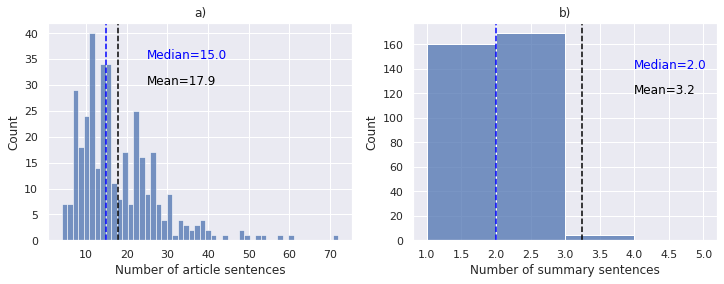

In [ ]:
sns.set(rc={'figure.figsize':(12,4)})
fig, (ax1, ax2) = plt.subplots(1,2)

sns.histplot(data=df1, x='article_num_sentences', bins=50, ax=ax1)
ax1.set_xlabel("Number of article sentences", fontsize = 12)
ax1.axvline(x=df1['article_num_sentences'].median(),color='blue',ls='--', lw=1.5)
ax1.text(25, 35, f"Median={df1['article_num_sentences'].median()}", horizontalalignment='left', size='medium', color='blue')
ax1.axvline(x=df1['article_num_sentences'].mean(),color='black',ls='--', lw=1.5)
ax1.text(25, 30, f"Mean={df1['article_num_sentences'].mean().round(1)}", horizontalalignment='left',size='medium', color='black')
ax1.set_title('a)')

sns.histplot(data=df1, x='highlights_num_sentences', bins=np.arange(1,6), ax=ax2)
ax2.set_xlabel("Number of summary sentences", fontsize = 12)
ax2.axvline(x=df1['highlights_num_sentences'].median(),color='blue',ls='--', lw=1.5)
ax2.text(4, 140, f"Median={df1['highlights_num_sentences'].median()}", horizontalalignment='left', size='medium', color='blue')
ax2.axvline(x=df1['highlights_num_sentences'].mean(),color='black',ls='--', lw=1.5)
ax2.text(4, 120, f"Mean={df1['highlights_num_sentences'].mean().round(1)}", horizontalalignment='left',size='medium', color='black')
ax2.set_title('b)')

plt.savefig('/content/sample_data/sentence_dist_amr.png', dpi=1200)

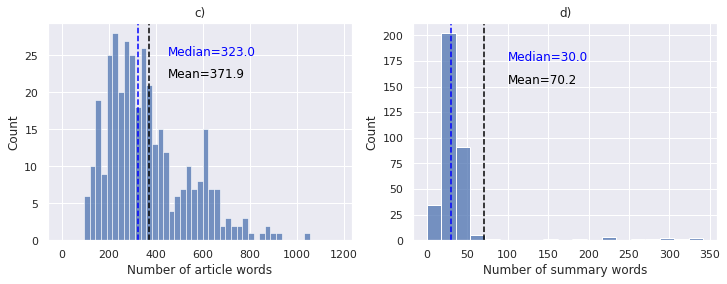

In [ ]:
sns.set(rc={'figure.figsize':(12,4)})
fig, (ax3, ax4) = plt.subplots(1,2)
sns.histplot(data=df1, x='article_num_words', bins=np.arange(0,1200,24), ax=ax3)
ax3.set_xlabel("Number of article words", fontsize = 12)
ax3.axvline(x=df1['article_num_words'].median(),color='blue',ls='--', lw=1.5)
ax3.text(450, 25, f"Median={df1['article_num_words'].median()}", horizontalalignment='left', size='medium', color='blue')
ax3.axvline(x=df1['article_num_words'].mean(),color='black',ls='--', lw=1.5)
ax3.text(450, 22, f"Mean={df1['article_num_words'].mean().round(1)}", horizontalalignment='left',size='medium', color='black')
ax3.set_title('c)')

sns.histplot(data=df1, x='highlights_num_words', bins=np.arange(0,360,18), ax=ax4)
ax4.set_xlabel("Number of summary words", fontsize = 12)
ax4.axvline(x=df1['highlights_num_words'].median(),color='blue',ls='--', lw=1.5)
ax4.text(100, 175, f"Median={df1['highlights_num_words'].median()}", horizontalalignment='left', size='medium', color='blue')
ax4.axvline(x=df1['highlights_num_words'].mean(),color='black',ls='--', lw=1.5)
ax4.text(100, 153, f"Mean={df1['highlights_num_words'].mean().round(1)}", horizontalalignment='left',size='medium', color='black')
ax4.set_title('d)')

plt.savefig('/content/sample_data/word_dist_amr.png', dpi=1200)

#### Percentage of MFD 2.0 words for opinion articles vs other articles

In [ ]:
# Load MFD2.0 dictionary
with open('/content/drive/MyDrive/mfd2.0.txt','r') as f:
    mfd_dict = {}
    for line in f:
        items = line.split('\t')
        key, value = items[0], items[1].split('\n')[0]
        mfd_dict[key] = value

In [ ]:
def get_mfd_info(dataframe):

    # Create tokeniser which removes punctuation from sentences
    tokenizer = nltk.RegexpTokenizer(r"\w+")

    # Count number of MFD words per article
    num_mfd_words = []
    num_care_words = []
    num_fairness_words = []
    num_loyalty_words = []
    num_authority_words = []
    num_sanctity_words = []

    for idx, art in dataframe.iterrows():

        count = 0
        care_count = 0
        fairness_count = 0
        loyalty_count = 0
        authority_count = 0
        sanctity_count = 0

        for sent in art['article_sentences']:
            words = tokenizer.tokenize(sent)
            for word in words:
                if word in mfd_dict.keys():
                    count += 1
                    if mfd_dict[word] == '1' or mfd_dict[word] == '2':
                        care_count += 1
                    if mfd_dict[word] == '3' or mfd_dict[word] == '4':
                        fairness_count += 1
                    if mfd_dict[word] == '5' or mfd_dict[word] == '6':
                        loyalty_count += 1
                    if mfd_dict[word] == '7' or mfd_dict[word] == '8':
                        authority_count += 1
                    if mfd_dict[word] == '9' or mfd_dict[word] == '10':
                        sanctity_count += 1

        num_mfd_words.append(count)
        num_care_words.append(care_count)
        num_fairness_words.append(fairness_count)
        num_loyalty_words.append(loyalty_count)
        num_authority_words.append(authority_count)
        num_sanctity_words.append(sanctity_count)

    dataframe['num_mfd_words'] = num_mfd_words
    dataframe['num_care_words'] = num_care_words
    dataframe['num_fairness_words'] = num_fairness_words
    dataframe['num_loyalty_words'] = num_loyalty_words
    dataframe['num_authority_words'] = num_authority_words
    dataframe['num_sanctity_words'] = num_sanctity_words

    # Calculate percentage of words in the MFD dictionary
    dataframe['%_mfd_words'] = dataframe['num_mfd_words'] / dataframe['article_num_words'] * 100
    return dataframe

In [ ]:
df1 = get_mfd_info(df1)

In [ ]:
# Obtain MFD percentages for unused articles
df2 = get_sentence_info(extra_corpus)
df2 = get_mfd_info(df2)

In [ ]:
df_total = pd.concat([df1.assign(dataset='Opinion'), df2.assign(dataset='Other')])

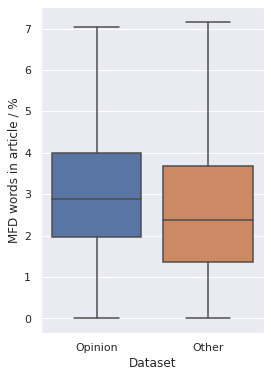

In [ ]:
sns.set(rc={'figure.figsize':(4,6)})
fig = sns.boxplot(data=df_total, x='dataset', y='%_mfd_words', showfliers=False)
fig.set_xlabel("Dataset", fontsize = 12)
fig.set_ylabel("MFD words in article / %", fontsize = 12)
fig.figure.savefig('/content/sample_data/mfd_stats.png')

In [ ]:
statistics = df_total.groupby('dataset')['%_mfd_words'].describe().transpose()
statistics

dataset,Opinion,Other
count,4898.000000,282162.000000
mean,3.116543,2.672191
std,1.598299,1.682620
min,0.000000,0.000000
25%,1.958451,1.368421
50%,2.887538,2.383532
75%,3.994057,3.685632
max,12.254902,20.000000


In [ ]:
import scipy.stats as stats
opinion_sample = list(df1['%_mfd_words'])
random_ints = []
while len(random_ints) < len(opinion_sample):
    i = random.randint(0,len(df2))
    if i not in random_ints:
        random_ints.append(i)
print(len(random_ints))
other_sample = list(df2.iloc[random_ints]['%_mfd_words'])
stats.ttest_rel(a=opinion_sample, b=other_sample)

4898


Ttest_relResult(statistic=13.924611202311434, pvalue=2.9703445756569775e-43)

#### Words per moral foundation

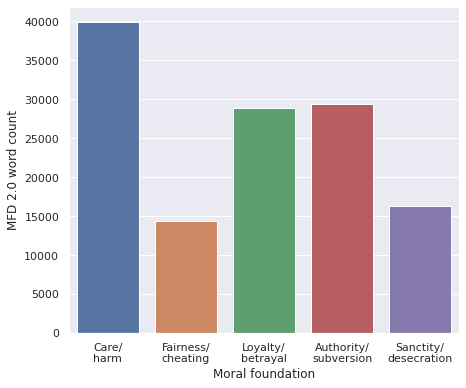

In [ ]:
total_per_mf = [sum(df1['num_care_words']), 
                sum(df1['num_fairness_words']), 
                sum(df1['num_loyalty_words']), 
                sum(df1['num_authority_words']), 
                sum(df1['num_sanctity_words'])]
mfs = ['Care/\nharm', 
              'Fairness/\ncheating', 
              'Loyalty/\nbetrayal', 
              'Authority/\nsubversion', 
              'Sanctity/\ndesecration']

sns.set(rc={'figure.figsize':(7,6)})
fig = sns.barplot(x=mfs, y=total_per_mf)
fig.set_xlabel('Moral foundation')
fig.set_ylabel('MFD 2.0 word count')
fig.figure.savefig('/content/sample_data/word_count.png')

#### Common themes for each moral foundation

In [ ]:
def mf_word_soup(dataframe, category, top=10):

    # Obtain X articles with the highest number of words relating to the MF
    dataframe.sort_values(category, ascending=False, inplace=True)
    top_X = dataframe.iloc[0:top]

    # Create a bag of words for the top X articles
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    BoW = []
    for idx, art in top_X.iterrows():
        for sent in art['article_sentences']:
            words = tokenizer.tokenize(sent)
            for word in words:
                BoW.append(word)

    # Remove stop words
    BoW_wo_stopwords = [word for word in BoW if not word in stopwords.words()]

    # Join words into string
    BoW_string = ' '.join((str(n) for n in BoW_wo_stopwords))
    return BoW_string


def print_wordcloud(BoW_string, filename, colormap='viridis'):
    wordcloud = WordCloud(background_color="white", colormap=colormap).generate(BoW_string)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wordcloud.to_file(f'/content/sample_data/{filename}.png')

In [ ]:
care_soup = mf_word_soup(df1, 'num_care_words')
fairnenss_soup = mf_word_soup(df1, 'num_fairness_words')
loyalty_soup = mf_word_soup(df1, 'num_loyalty_words')
authority_soup = mf_word_soup(df1, 'num_authority_words')
sanctity_soup = mf_word_soup(df1, 'num_sanctity_words')

print('--- Care/Harm foundation ---')
print_wordcloud(care_soup, 'care', 'cividis')
print('--- Fairness/Cheating foundation ---')
print_wordcloud(fairnenss_soup, 'fairness', 'cividis')
print('--- Loyalty/Betrayal foundation ---')
print_wordcloud(loyalty_soup, 'loyalty', 'cividis')
print('--- Authority/Subversion foundation ---')
print_wordcloud(authority_soup, 'authority', 'cividis')
print('--- Sanctity/Degradation foundation ---')
print_wordcloud(sanctity_soup, 'sanctity', 'cividis')

# II. Moral summary analysis

### Relative first summary sentence position

In [ ]:
# Find average sentence position of first sentence of moral summary
with open('/content/drive/MyDrive/IP/datasets/test_inputs/snt_stories.txt', 'r', encoding='latin-1') as f:
    stories = f.readlines()
    test_stories = []
    for story in stories:
        test_stories.append(nltk.tokenize.sent_tokenize(story))
    

with open('/content/drive/MyDrive/IP/datasets/__archived/test_selection_w_openers.csv', 'r', newline='') as file:
    reader = csv.DictReader(file)
    fieldnames = ['pos',	'test', 'no',	'article	highlights',	'id',	'moral summary',	'position']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    ex_pos = []
    relative_pos = []

    for i, row in enumerate(reader):
        extract = row['position']
        for j, sent in enumerate(test_stories[i]):
            if extract in sent:
                ex_pos.append(j+1)
                relative_pos.append(100 * (j+1) / (len(test_stories[i])+1))

df_pos = pd.DataFrame()
df_pos['ex_pos'] = ex_pos
df_pos['relative_pos'] = relative_pos

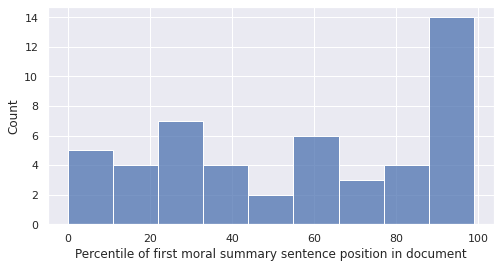

In [ ]:
sns.set(rc={'figure.figsize':(8,4)})
fig, ax1 = plt.subplots(1,1)

sns.histplot(data=df_pos, x='relative_pos', bins=np.arange(0,100, 11), ax=ax1)
ax1.set_xlabel("Percentile of first moral summary sentence position in document", fontsize = 12)
plt.savefig('/content/sample_data/percentiles.png', dpi=1600)

### MFD analysis

In [ ]:
from ast import literal_eval
import ast
df_test = pd.read_csv('/content/drive/MyDrive/IP/datasets/processed_test.csv')

In [ ]:
# Load MFD2.0 dictionary
with open('/content/drive/MyDrive/mfd2.0.txt','r', encoding='latin-1') as f:
    mfd_dict = {}
    for line in f:
        items = line.split('\t')
        key, value = items[0], items[1].split('\n')[0]
        mfd_dict[key] = value

In [ ]:
def get_mfd_summary_info(dataframe, summ_type):

    # Create tokeniser which removes punctuation from sentences
    tokenizer = nltk.RegexpTokenizer(r"\w+")

    num_words = []
    num_mfd_words = []
    num_care_words = []
    num_fairness_words = []
    num_loyalty_words = []
    num_authority_words = []
    num_sanctity_words = []

    for idx, art in dataframe.iterrows():

        word_count = 0
        count = 0
        care_count = 0
        fairness_count = 0
        loyalty_count = 0
        authority_count = 0
        sanctity_count = 0

        for sent in eval(art[f'{summ_type}_sentences']):
            words = tokenizer.tokenize(sent)
            for word in words:
                word_count += 1
                if word in mfd_dict.keys():
                    count += 1
                    if mfd_dict[word] == '1' or mfd_dict[word] == '2':
                        care_count += 1
                    if mfd_dict[word] == '3' or mfd_dict[word] == '4':
                        fairness_count += 1
                    if mfd_dict[word] == '5' or mfd_dict[word] == '6':
                        loyalty_count += 1
                    if mfd_dict[word] == '7' or mfd_dict[word] == '8':
                        authority_count += 1
                    if mfd_dict[word] == '9' or mfd_dict[word] == '10':
                        sanctity_count += 1

        num_words.append(word_count)
        num_mfd_words.append(count)
        num_care_words.append(care_count)
        num_fairness_words.append(fairness_count)
        num_loyalty_words.append(loyalty_count)
        num_authority_words.append(authority_count)
        num_sanctity_words.append(sanctity_count)

    dataframe['num_words'] = num_words
    dataframe['num_mfd_words'] = num_mfd_words
    dataframe['num_care_words'] = num_care_words
    dataframe['num_fairness_words'] = num_fairness_words
    dataframe['num_loyalty_words'] = num_loyalty_words
    dataframe['num_authority_words'] = num_authority_words
    dataframe['num_sanctity_words'] = num_sanctity_words

    # Calculate percentage of words in the MFD dictionary
    dataframe['%_mfd_words'] = dataframe['num_mfd_words'] / dataframe['num_words'] * 100

    new_df = dataframe.copy()

    return new_df

In [ ]:
summary_mft_df = get_mfd_summary_info(df_test, 'summary')
moral_mft_df = get_mfd_summary_info(df_test, 'moral')

In [ ]:
mft_df = pd.concat([summary_mft_df.assign(dataset='Gold-standard'), moral_mft_df.assign(dataset='Moral')])

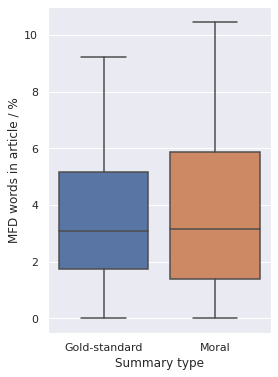

In [ ]:
sns.set(rc={'figure.figsize':(4,6)})
fig = sns.boxplot(data=mft_df, x='dataset', y='%_mfd_words', showfliers=False)
fig.set_xlabel("Summary type", fontsize = 12)
fig.set_ylabel("MFD words in article / %", fontsize = 12)
fig.figure.savefig('/content/sample_data/mfd_stats.png', dpi=1600)

In [ ]:
statistics = mft_df.groupby('dataset')['%_mfd_words'].describe().transpose()
statistics

dataset,Gold-standard,Moral
count,50.000000,50.000000
mean,3.619215,3.830128
std,3.332515,3.149069
min,0.000000,0.000000
25%,1.762218,1.403986
50%,3.102453,3.166667
75%,5.172414,5.882353
max,15.384615,13.432836


In [ ]:
import scipy.stats as stats
moral_stats = list(moral_mft_df['%_mfd_words'])
summary_stats = list(summary_mft_df['%_mfd_words'])
stats.ttest_rel(a=moral_stats, b=summary_stats)

Ttest_relResult(statistic=0.4615232949588055, pvalue=0.646465587411714)

### Further MFD analysis: article vs summaries

In [ ]:
def get_all_mfd_info(dataframe):

    # Create tokeniser which removes punctuation from sentences
    tokenizer = nltk.RegexpTokenizer(r"\w+")

    # Count number of MFD words per article


    for text in ['article', 'highlights']:

        num_mfd_words = []
        num_care_words = []
        num_fairness_words = []
        num_loyalty_words = []
        num_authority_words = []
        num_sanctity_words = []
        
        for idx, art in dataframe.iterrows():

            count = 0
            care_count = 0
            fairness_count = 0
            loyalty_count = 0
            authority_count = 0
            sanctity_count = 0

            for sent in art[f'{text}_sentences']:
                words = tokenizer.tokenize(sent)
                for word in words:
                    if word in mfd_dict.keys():
                        count += 1
                        if mfd_dict[word] == '1' or mfd_dict[word] == '2':
                            care_count += 1
                        if mfd_dict[word] == '3' or mfd_dict[word] == '4':
                            fairness_count += 1
                        if mfd_dict[word] == '5' or mfd_dict[word] == '6':
                            loyalty_count += 1
                        if mfd_dict[word] == '7' or mfd_dict[word] == '8':
                            authority_count += 1
                        if mfd_dict[word] == '9' or mfd_dict[word] == '10':
                            sanctity_count += 1

            num_mfd_words.append(count)
            num_care_words.append(care_count)
            num_fairness_words.append(fairness_count)
            num_loyalty_words.append(loyalty_count)
            num_authority_words.append(authority_count)
            num_sanctity_words.append(sanctity_count)

        dataframe[f'{text}_num_mfd_words'] = num_mfd_words
        dataframe[f'{text}_num_care_words'] = num_care_words
        dataframe[f'{text}_num_fairness_words'] = num_fairness_words
        dataframe[f'{text}_num_loyalty_words'] = num_loyalty_words
        dataframe[f'{text}_num_authority_words'] = num_authority_words
        dataframe[f'{text}_num_sanctity_words'] = num_sanctity_words

        # Calculate percentage of words in the MFD dictionary
        dataframe[f'{text}_%_mfd_words'] = dataframe[f'{text}_num_mfd_words'] / dataframe[f'{text}_num_words'] * 100
    return dataframe

In [ ]:
df_all = get_mfd_info(df1)

In [ ]:
article_stats = list(df_all['article_%_mfd_words'])
summary_stats = list(df_all['highlights_%_mfd_words'])
stats.ttest_rel(a=article_stats, b=summary_stats)

Ttest_relResult(statistic=-11.380600099940512, pvalue=1.2278259429302448e-29)

# Miscellaneous

In [ ]:
with open('/content/drive/MyDrive/IP/datasets/amr_proxy_inputs/snt_stories.txt', 'r', encoding='latin-1') as f:
    amr_stories = f.readlines()

with open('/content/drive/MyDrive/IP/datasets/cnndm_inputs/snt_stories.txt', 'r', encoding='latin-1') as f:
    cnndm_stories = f.readlines()

In [ ]:
amr_prop = []
for story in amr_stories:
    unique_words = set()
    word_tokens = nltk.tokenize.word_tokenize(story)
    for word in word_tokens:
        unique_words.add(word)
    unique_prop = len(unique_words) / len(word_tokens)
    amr_prop.append(unique_prop)
average = sum(amr_prop) / len(amr_prop)
print(average)


0.4846131257951752


In [ ]:
cnndm_prop = []
for story in cnndm_stories:
    unique_words = set()
    word_tokens = nltk.tokenize.word_tokenize(story)
    for word in word_tokens:
        unique_words.add(word)
    unique_prop = len(unique_words) / len(word_tokens)
    cnndm_prop.append(unique_prop)
average = sum(cnndm_prop) / len(cnndm_prop)
print(average)

0.45947770875864624


### Summary length correlation

In [ ]:
top_nodes = np.array([10,10,10,15,15,15,20,20,20])
tn_multiplier = np.array([1,2,3,1,2,3,1,2,3])
node_breaks = [8,29,40,7,19,33,6,11,27]
node_breaks = np.array([i/(49) for i in node_breaks])
token_len = np.array([44.7,55.8,55.2,45.8,58.8,56.1,47.4,56.5,55.8])

df = pd.DataFrame()
df['c * TNM'] = top_nodes * tn_multiplier
df['TNM'] = tn_multiplier
df['% i'] = node_breaks
df['# tokens'] = token_len


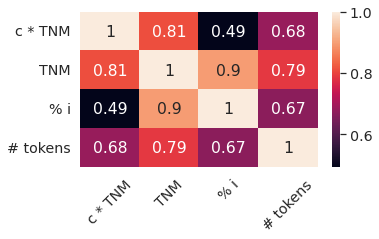

In [ ]:
corrMatrix = df.corr()
sns.set(font_scale=1.3)
plot = sns.heatmap(corrMatrix, annot=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout(pad=2)
heatmap = plot.get_figure()
heatmap.savefig('/content/sample_data/summary_heatmap.png', dpi=300)

In [ ]:
top_nodes = np.array([10,10,10,15,15,15,20,20,20])
tn_multiplier = np.array([1,2,3,1,2,3,1,2,3])
node_breaks = [12,36,47,9,21,40,7,14,35]
node_breaks = np.array([i/(49) for i in node_breaks])
token_len = np.array([52.1,55.7,57.1,51.6,57.5,60.4,53.3,56.6,57.9])

df = pd.DataFrame()
df['c * TNM'] = top_nodes * tn_multiplier
df['TNM'] = tn_multiplier
df['% i'] = node_breaks
df['# tokens'] = token_len


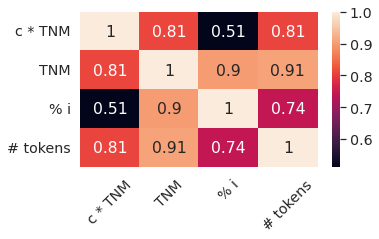

In [ ]:
corrMatrix = df.corr()
sns.set(font_scale=1.3)
plot = sns.heatmap(corrMatrix, annot=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout(pad=2)
heatmap = plot.get_figure()
heatmap.savefig('/content/sample_data/moral_heatmap.png', dpi=300)

### Foundations

In [ ]:
# with open ('/content/drive/MyDrive/IP/datasets/temp_results_table.csv', 'r', encoding='latin-1') as file:
table = pd.read_csv('/content/drive/MyDrive/IP/datasets/temp_results_table.csv')
table = table.set_index('Run')

In [ ]:
table.head(1)

,Relation,Foundation,MFT factor,R-1,P-1,R-2,P-2,R-L,Nodes,BLEU,CHRF++,METEOR
Run,,,,,,,,,,,,
10b,Min,None,5,0.221,0.305,0.03,0.043,0.144,0.258,0.016,0.205,0.145


In [ ]:
new_table = table[['R-1', 'P-1', 'R-2', 'P-2', 'R-L', 'Nodes', 'BLEU', 'CHRF++', 'METEOR' ]].reset_index()
new_table = new_table.append(new_table.loc['15b':'21'].mean(axis=0), ignore_index=True)
new_table = new_table.append(new_table.loc['21':].mean(axis=0), ignore_index=True)
new_table = new_table.iloc[[2,17,18]]
new_table.at[17, 'Run'] = '15b to 20'
new_table.at[18, 'Run'] = '21 to 26'
new_table = new_table.set_index('Run')
new_table

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ip

,R-1,P-1,R-2,P-2,R-L,Nodes,BLEU,CHRF++,METEOR
Run,,,,,,,,,
12b,0.200000,0.293000,0.0250,0.043000,0.1380,0.256000,0.0120,0.1950,0.132000
15b to 20,0.200000,0.293000,0.0250,0.043000,0.1380,0.256000,0.0120,0.1950,0.132000
21 to 26,0.198933,0.298133,0.0246,0.041467,0.1366,0.251133,0.0122,0.1942,0.133267


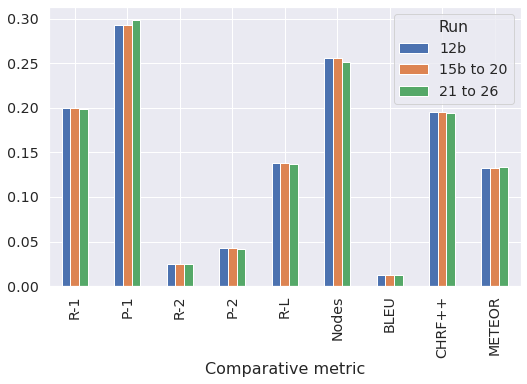

In [ ]:
sns.set(font_scale=1.3)
fig = new_table.transpose(copy=True).plot.bar(figsize=(8,6))
fig.set_xlabel("Comparative metric", fontsize = 16)
plt.tight_layout(pad=2)
fig.figure.savefig('/content/sample_data/foundation_plot.png', dpi=400)

# II. MFTC

In [ ]:
! pip install Twython
! pip install tweepy==v4.6.0
clear_output()

In [ ]:
import json
import sys
from collections import OrderedDict
from twython import Twython
import time

#Fill your Twitter API key and access token below
#Information can be found on the Twitter developer website:
#https://developer.twitter.com/en/docs/basics/authentication/guides/access-tokens.html

# Keys removed for security

def parse(input, corpus_name):

    output = f'/content/drive/MyDrive/MFTC/MFTC_output_{corpus_name}.json'
    try:
        temp = open(input)
    except:
        print("Please enter a valid input file")

    data = json.load(temp)
    counter = 0

    for d in data:
        #Skip over corpus without tweet ID's
        if(d["Corpus"] == "Davidson"):
            if(corpus_name == "Davidson"):
                print("Tweet text is not availble for the Davidson corpus. "
                      "You can use the tweet_ids and retrieve the text from "
                      "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv")
            continue

        if corpus_name == d["Corpus"]:
            for t in d["Tweets"]:
                id = t["tweet_id"]
                #retrieves tweet text if available
                try:
                    text, date = call_twitter_api(id)
                    print(text)
                    print(date)                    
                    t["tweet_text"] = text
                    t["date"] = date
                except:
                    t["tweet_text"] = 'no tweet text available'
                    t["date"] = 'no date available'

                #increment counter
                counter += 1

                #In order to deal with the Twitter API access limits
                if counter % 900 == 0:
                    print(f"Twitter API has timed out. Waiting 15 minutes before resuming script. Count = {counter}")
                    time.sleep(900)

                #reodering the json elements
                temp = t["annotations"]
                t.pop("annotations")
                t["annotations"] = temp
          
        else:
            continue

    check = False
    if(corpus_name != "all"):
        for d in data:
            if(d["Corpus"] == corpus_name):
                data = d
                check = True
                break
        if(check == False):
            print("Please enter a valid corpus name")

    with open(output, 'w') as outfile:
        json.dump(data, outfile, indent = 4)

def call_twitter_api(id):
    twitter = Twython(consumer_key, consumer_secret, access_token_key, access_token_secret)
    tweet = twitter.show_status(id=id)
    return tweet['text'], tweet['created_at']


input = '/content/drive/MyDrive/MFTC/MFTC_V4.json'
parse(input, 'Election')

Streaming output truncated to the last 5000 lines.
@GoodenBen when we detain children, leave people stranded at sea, bully the human rights commissioner, is it a stretch to lock up a doctor?
Wed Jun 10 22:54:13 +0000 2015
Mandatory minimum 5 years for fraud or dishonesty while holding or working in public office (including police)? #cdnpoli #Omnibus #BillC10
Fri Dec 02 17:25:39 +0000 2011
@TheREAL_OD lmfaoooooo moves 👏🏾👏🏾👏🏾
Sun Jul 03 20:14:23 +0000 2016
RT @ezrig45: God I love country music
Wed Sep 10 01:50:49 +0000 2014
"It's not rational arguments but emotions that cause belief in after life. Fear of death mainly. It's biologically useful though"
Fri Jan 03 20:25:20 +0000 2014
they be butt hurt 😂😂😂😂😂 https://t.co/2ImtDsSKm9
Fri Dec 30 19:01:40 +0000 2016
End the hate used to sell wars end the campaign of hatred used to justify killing innocents
Mon Feb 27 09:16:25 +0000 2017
RT @0lddutch: #sunTV Watching Ezra Levant is like watching Mr, Dressup without the kindness wit and charm.
Tu